In [1]:
import os
import glob
import pandas as pd
import numpy as np
import pandas_ta as ta
from tqdm import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

# ==============================================================================
# [설정] 경로 및 파라미터
# ==============================================================================
BASE_DIR = "./"
MODEL_RESULTS_DIR = os.path.join("model_results", "4시간봉", "2025-12-04", "fold_results", "direction_t4800")
RAW_DATA_PATH_4H = "eth_4hour_all.csv"
RAW_DATA_PATH_5M = "eth_5min_krw.csv"

TARGET_MODELS = [
    "LightGBM", "XGBoost", "CatBoost", "RandomForest", 
    "GradientBoosting", "HistGradientBoosting", "AdaBoost", 
    "LogisticRegression", "StackingEnsemble",
    "LSTM", "BiLSTM", "GRU"
]

ATR_MULTIPLIER_PROFIT = 0.3  
ATR_MULTIPLIER_STOP = 0.2    
FEE_RATE = 0.001
META_THRESHOLD = 0.60      

# ==============================================================================
# [1] 데이터 로드 함수 (기존 유지)
# ==============================================================================
def load_market_data():

    print("Loading 4H Market Data (Features)...")
    df_4h = pd.read_csv(RAW_DATA_PATH_4H)
    df_4h['date'] = pd.to_datetime(df_4h['date'])
    df_4h = df_4h.sort_values('date').reset_index(drop=True)
    
    close = df_4h['ETH_Close']
    high = df_4h.get('ETH_High', close)
    low = df_4h.get('ETH_Low', close)
    volume = df_4h.get('ETH_Volume', pd.Series(1, index=df_4h.index))

    if 'ETH_BB_WIDTH' not in df_4h.columns:
        bb = ta.bbands(close, length=20, std=2)
        if bb is not None:
            bbu = bb[bb.columns[0]]
            bbl = bb[bb.columns[2]]
            bbm = bb[bb.columns[1]]
            df_4h['BB_WIDTH'] = ((bbu - bbl) / (bbm + 1e-9)) * 100
    else:
        df_4h['BB_WIDTH'] = df_4h['ETH_BB_WIDTH']

    if 'ETH_NATR_14' not in df_4h.columns:
        atr = ta.atr(high, low, close, length=14)
        df_4h['NATR_14'] = (atr / close) * 100
        df_4h['ATR_14'] = atr 
    else:
        df_4h['NATR_14'] = df_4h['ETH_NATR_14']
        if 'ETH_ATR_14' in df_4h.columns:
             df_4h['ATR_14'] = df_4h['ETH_ATR_14']
        else:
             df_4h['ATR_14'] = ta.atr(high, low, close, length=14)

    if 'ETH_RSI_14' not in df_4h.columns:
        df_4h['RSI_14'] = ta.rsi(close, length=14)
    else:
        df_4h['RSI_14'] = df_4h['ETH_RSI_14']

    if 'ETH_Vol_Ratio' not in df_4h.columns:
        df_4h['Vol_Ratio'] = volume / (volume.rolling(20).mean() + 1e-9)
    else:
        df_4h['Vol_Ratio'] = df_4h['ETH_Vol_Ratio']
        
    if 'ETH_KP_Zscore' in df_4h.columns:
        df_4h['KP_Zscore'] = df_4h['ETH_KP_Zscore']
    else:
        df_4h['KP_Zscore'] = 0

    if 'FR_Trend' not in df_4h.columns:
        if 'fundingRate' in df_4h.columns:
             df_4h['FR_Trend'] = df_4h['fundingRate'].rolling(6).mean()
        else:
             df_4h['FR_Trend'] = 0
    
    meta_cols = ['date', 'next_open', 'ATR_14', 'BB_WIDTH', 'NATR_14', 'RSI_14', 'Vol_Ratio', 'KP_Zscore', 'FR_Trend']
    if 'next_open' not in df_4h.columns:
        df_4h['next_open'] = df_4h['ETH_Open'].shift(-1)
        
    df_4h = df_4h[meta_cols].dropna()

    print("Loading 5M Market Data (Labeling)...")
    df_5m = pd.read_csv(RAW_DATA_PATH_5M)
    df_5m['date'] = pd.to_datetime(df_5m['date'])
    cols_map = {'ETH_High': 'high', 'ETH_Low': 'low', 'ETH_Close': 'close', 'ETH_Open': 'open'}
    df_5m = df_5m.rename(columns=cols_map)
    df_5m = df_5m[['date', 'high', 'low', 'close']].sort_values('date').set_index('date')
    
    return df_4h, df_5m

# ==============================================================================
# [2] & [3] 함수 (기존 동일하므로 생략, 위 코드 그대로 사용)
# ==============================================================================
def check_barrier_success(entry_time, entry_price, volatility, df_5m):
    # ... (위 코드 복사) ...
    start_time = entry_time
    end_time = start_time + pd.Timedelta(hours=4)
    
    tp_price = entry_price + (volatility * ATR_MULTIPLIER_PROFIT)
    sl_price = entry_price - (volatility * ATR_MULTIPLIER_STOP)
    
    try:
        subset = df_5m.loc[start_time:end_time] 
        if subset.empty: return 0 
            
        for t, row in subset.iterrows():
            if row['low'] <= sl_price: return 0 
            if row['high'] >= tp_price: return 1 
        
        final_close = subset.iloc[-1]['close']
        if final_close > entry_price * (1 + FEE_RATE): return 1
        else: return 0
    except KeyError: return 0

def build_meta_dataset(model_name, fold_dirs, df_4h, df_5m):

    meta_train_list = []
    wf_test_list = []     # Walk-Forward Test
    holdout_test_list = [] # Final Holdout Test
    
    for fold_dir in fold_dirs:
        fold_name = os.path.basename(fold_dir)
        is_holdout = "final_holdout" in fold_name
        
        pred_path = os.path.join(fold_dir, f"{model_name}_predictions.csv")
        if not os.path.exists(pred_path): continue
            
        df_pred = pd.read_csv(pred_path)
        df_pred['date'] = pd.to_datetime(df_pred['date'])
        
        # Buy 신호만 필터링
        df_buy = df_pred[df_pred['pred_direction'] == 1].copy()
        if df_buy.empty: continue

        # 시장 데이터 병합
        df_merged = pd.merge(df_buy, df_4h, on='date', how='left')
        df_merged = df_merged.dropna(subset=['ATR_14'])
        
        # 추가 피처
        df_merged['proba_dist'] = abs(df_merged['pred_proba_up'] - 0.5)
        df_merged['fold_name'] = fold_name # 폴드 추적용

        # 라벨링
        labels = []
        for idx, row in df_merged.iterrows():
            res = check_barrier_success(row['date'], row['next_open'], row['ATR_14'], df_5m)
            labels.append(res)
        df_merged['y_meta'] = labels
        
        # 데이터 분리 저장
        meta_train_list.append(df_merged[df_merged['dataset'] == 'Val'])
        
        if is_holdout:
            holdout_test_list.append(df_merged[df_merged['dataset'] == 'Test'])
        else:
            wf_test_list.append(df_merged[df_merged['dataset'] == 'Test'])
            
    return (
        pd.concat(meta_train_list, ignore_index=True) if meta_train_list else pd.DataFrame(),
        pd.concat(wf_test_list, ignore_index=True) if wf_test_list else pd.DataFrame(),
        pd.concat(holdout_test_list, ignore_index=True) if holdout_test_list else pd.DataFrame()
    )



In [6]:
def find_optimal_threshold(y_true, y_probs):
    """ Val 데이터에서 최적 임계값 찾기 """
    best_th = 0.5
    best_score = -np.inf
    for th in np.arange(0.50, 0.90, 0.01):
        signals = (y_probs > th).astype(int)
        if signals.sum() < 5: continue # 최소 거래 조건
        
        win_rate = y_true[signals == 1].mean()
        trade_count = signals.sum()
        
        # 점수: 승률 가중치 높게, 거래량 로그 적용
        score = (win_rate - 0.5) * 2 + np.log1p(trade_count) * 0.1
        
        if score > best_score:
            best_score = score
            best_th = th
    return best_th

if __name__ == "__main__":
    df_4h, df_5m = load_market_data()
    # Fold 1 ~ Fold 9 (Holdout 포함) 순서대로 정렬 필수!
    fold_dirs = sorted(glob.glob(os.path.join(MODEL_RESULTS_DIR, "fold_*")))
    
    print(f"\n{'='*60}")
    print(f"🚀 Starting STRICT Walk-Forward Meta-Labeling")
    print(f"{'='*60}\n")
    
    # 누적 학습을 위한 리스트
    accumulated_train_list = [] 
    
    summary_results = []

    for model_name in TARGET_MODELS:
        print(f"\n🔵 Processing {model_name} (Expanding Window)...")
        

        wf_results = [] 

        accumulated_train_df = pd.DataFrame()
        
        for fold_dir in tqdm(fold_dirs, desc="Walking Forward"):
            fold_name = os.path.basename(fold_dir)
            

            pred_path = os.path.join(fold_dir, f"{model_name}_predictions.csv")
            if not os.path.exists(pred_path): continue
            
            df_pred = pd.read_csv(pred_path)
            df_pred['date'] = pd.to_datetime(df_pred['date'])
            df_buy = df_pred[df_pred['pred_direction'] == 1].copy()
            
            if df_buy.empty: continue
            
            df_merged = pd.merge(df_buy, df_4h, on='date', how='left').dropna(subset=['ATR_14'])
            df_merged['proba_dist'] = abs(df_merged['pred_proba_up'] - 0.5)
            
            # 라벨링
            labels = []
            for idx, row in df_merged.iterrows():
                labels.append(check_barrier_success(row['date'], row['next_open'], row['ATR_14'], df_5m))
            df_merged['y_meta'] = labels
            
            # 현재 Fold의 데이터
            current_val = df_merged[df_merged['dataset'] == 'Val']
            current_test = df_merged[df_merged['dataset'] == 'Test']

            if len(accumulated_train_df) > 50: 
                use_features = [
                    'pred_proba_up', 'proba_dist', 'BB_WIDTH', 'NATR_14', 
                    'RSI_14', 'Vol_Ratio', 'KP_Zscore', 'FR_Trend'
                ]
                use_features = [c for c in use_features if c in accumulated_train_df.columns]
                

                meta_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, 
                                           random_state=42, verbosity=0)
                meta_model.fit(accumulated_train_df[use_features], accumulated_train_df['y_meta'])
                

                train_probs = meta_model.predict_proba(accumulated_train_df[use_features])[:, 1]
                best_th = find_optimal_threshold(accumulated_train_df['y_meta'], train_probs)
                
                # --- 현재 Fold Test 예측 ---
                if len(current_test) > 0:
                    test_probs = meta_model.predict_proba(current_test[use_features])[:, 1]
                    test_signals = (test_probs > best_th).astype(int)
                    
                    # 결과 저장
                    for y, sig in zip(current_test['y_meta'], test_signals):
                        wf_results.append({'y_real': y, 'y_pred': sig, 'fold': fold_name, 'type': 'Meta'})

            # 3. 현재 Fold의 Validation 데이터를 누적 학습 데이터에 추가 (다음 Fold를 위해)
            accumulated_train_df = pd.concat([accumulated_train_df, current_val])
            
        # --- 모델별 최종 리포트 ---
        if wf_results:
            res_df = pd.DataFrame(wf_results)
            
            # 전체 기간 성적
            total_trades = res_df['y_pred'].sum()
            if total_trades > 0:
                total_wr = res_df[res_df['y_pred'] == 1]['y_real'].mean()
                print(f"   📊 {model_name} Total Walk-Forward: Win-Rate {total_wr:.2%} ({total_trades} trades)")
                
                # Holdout(마지막 Fold)만 따로 보기
                holdout_df = res_df[res_df['fold'].str.contains("final_holdout")]
                ho_trades = holdout_df['y_pred'].sum()
                ho_wr = holdout_df[holdout_df['y_pred'] == 1]['y_real'].mean() if ho_trades > 0 else 0.0
                
                print(f"      👉 Final Holdout: Win-Rate {ho_wr:.2%} ({ho_trades} trades)")
                summary_results.append({'Model': model_name, 'WF_WR': total_wr, 'Holdout_WR': ho_wr, 'Trades': ho_trades})
            else:
                print(f"   ⚠️ {model_name}: No trades triggered.")

    # 랭킹 출력
    if summary_results:
        print(f"\n{'='*60}")
        print("🏆 Strict Walk-Forward Ranking")
        print(f"{'='*60}")
        print(pd.DataFrame(summary_results).sort_values('Holdout_WinRate', ascending=False))

Loading 4H Market Data (Features)...
Loading 5M Market Data (Labeling)...

🚀 Starting STRICT Walk-Forward Meta-Labeling


🔵 Processing LightGBM (Expanding Window)...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.63s/it]


   📊 LightGBM Total Walk-Forward: Win-Rate 41.07% (112 trades)
      👉 Final Holdout: Win-Rate 62.50% (8 trades)

🔵 Processing XGBoost (Expanding Window)...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:14<00:00,  1.64s/it]


   📊 XGBoost Total Walk-Forward: Win-Rate 38.69% (168 trades)
      👉 Final Holdout: Win-Rate 75.00% (4 trades)

🔵 Processing CatBoost (Expanding Window)...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.55s/it]


   📊 CatBoost Total Walk-Forward: Win-Rate 42.37% (177 trades)
      👉 Final Holdout: Win-Rate 56.25% (16 trades)

🔵 Processing RandomForest (Expanding Window)...


Walking Forward:  33%|██████████████████████████████████████████████████████████████▋                                                                                                                             | 3/9 [00:04<00:08,  1.41s/it]


KeyboardInterrupt: 

In [2]:
import os
import glob
import re
import pandas as pd
import numpy as np
import pandas_ta as ta
from tqdm import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ==============================================================================
# [설정] 경로 및 파라미터
# ==============================================================================
BASE_DIR = "./"
MODEL_RESULTS_DIR = os.path.join("model_results", "4hour", "2025-12-04", "fold_results", "direction_t4800")
RAW_DATA_PATH_4H = "eth_4hour_all.csv"
RAW_DATA_PATH_5M = "eth_5min_krw.csv"

TARGET_MODELS = [
    "LightGBM", "XGBoost", "CatBoost", "RandomForest", 
    "GradientBoosting", "HistGradientBoosting", "AdaBoost", 
    "LogisticRegression", "StackingEnsemble",
]

# [전략 파라미터] 손익비 1.0 : 0.7 / 수수료 0.1%
ATR_MULTIPLIER_PROFIT = 1.0
ATR_MULTIPLIER_STOP = 0.7
FEE_RATE = 0.001 

# ==============================================================================
# [핵심] PnL Engine (수익률 계산기)
# ==============================================================================
def check_barrier_result(entry_time, entry_price, volatility, df_5m):
    """
    트리플 베리어 결과를 (성공여부, 수익률) 튜플로 반환
    - 보수적 검증: Low(손절) 먼저 체크
    - 수수료 반영
    """
    # [수정] 진입 직후부터 감시 시작
    start_time = entry_time
    end_time = start_time + pd.Timedelta(hours=4)
    
    tp_price = entry_price + (volatility * ATR_MULTIPLIER_PROFIT)
    sl_price = entry_price - (volatility * ATR_MULTIPLIER_STOP)
    
    try:
        subset = df_5m.loc[start_time:end_time]
        if subset.empty: return 0, -FEE_RATE # 데이터 누락 시 진입비용만 손실
        
        for t, row in subset.iterrows():
            # 1. 손절 먼저 체크 (보수적)
            if row['low'] <= sl_price:
                # 손절 확정: (손절가 - 진입가)/진입가 - 수수료
                loss_pct = (sl_price - entry_price) / entry_price - FEE_RATE
                return 0, loss_pct
            
            # 2. 익절 체크
            if row['high'] >= tp_price:
                # 익절 확정: (익절가 - 진입가)/진입가 - 수수료
                profit_pct = (tp_price - entry_price) / entry_price - FEE_RATE
                return 1, profit_pct
        
        # 3. 시간 초과 (Time Exit) -> 종가 청산
        exit_price = subset.iloc[-1]['close']
        final_ret = (exit_price - entry_price) / entry_price - FEE_RATE
        
        # 수익이면 1, 손실이면 0
        return (1, final_ret) if final_ret > 0 else (0, final_ret)
        
    except KeyError: return 0, -FEE_RATE

def calculate_metrics(returns):
    """
    수익률 리스트 -> MDD, Sharpe, Total Return 계산
    (복리 기준)
    """
    if len(returns) == 0: return 0.0, 0.0, 0.0
    
    # 복리 누적 자산 곡선 (Equity Curve)
    equity_curve = np.cumprod(1 + np.array(returns))
    
    # 1. 총 수익률
    total_return = equity_curve[-1] - 1
    
    # 2. MDD
    running_max = np.maximum.accumulate(equity_curve)
    drawdown = (equity_curve - running_max) / running_max
    mdd = drawdown.min()
    
    # 3. Sharpe (간이)
    mean_ret = np.mean(returns)
    std_ret = np.std(returns) + 1e-9
    sharpe = mean_ret / std_ret * np.sqrt(len(returns))
    
    return total_return, mdd, sharpe

# ==============================================================================
# [유틸리티 함수]
# ==============================================================================
def get_fold_number(folder_path):
    match = re.search(r'fold_(\d+)', os.path.basename(folder_path))
    return int(match.group(1)) if match else 999

def load_market_data():
    print("Loading 4H Market Data (Features)...")
    df_4h = pd.read_csv(RAW_DATA_PATH_4H)
    df_4h['date'] = pd.to_datetime(df_4h['date'])
    df_4h = df_4h.sort_values('date').reset_index(drop=True)
    
    close = df_4h['ETH_Close']
    high = df_4h.get('ETH_High', close)
    low = df_4h.get('ETH_Low', close)
    volume = df_4h.get('ETH_Volume', pd.Series(1, index=df_4h.index))

    # --- 기술적 지표 계산 ---
    if 'ETH_BB_WIDTH' not in df_4h.columns:
        bb = ta.bbands(close, length=20, std=2)
        if bb is not None:
            bbu = bb[bb.columns[0]]; bbl = bb[bb.columns[2]]; bbm = bb[bb.columns[1]]
            df_4h['BB_WIDTH'] = ((bbu - bbl) / (bbm + 1e-9)) * 100
    else: df_4h['BB_WIDTH'] = df_4h['ETH_BB_WIDTH']

    if 'ETH_NATR_14' not in df_4h.columns:
        atr = ta.atr(high, low, close, length=14)
        df_4h['NATR_14'] = (atr / close) * 100
        df_4h['ATR_14'] = atr 
    else:
        df_4h['NATR_14'] = df_4h['ETH_NATR_14']
        df_4h['ATR_14'] = df_4h.get('ETH_ATR_14', ta.atr(high, low, close, length=14))

    if 'ETH_RSI_14' not in df_4h.columns: df_4h['RSI_14'] = ta.rsi(close, length=14)
    else: df_4h['RSI_14'] = df_4h['ETH_RSI_14']

    if 'ETH_Vol_Ratio' not in df_4h.columns: df_4h['Vol_Ratio'] = volume / (volume.rolling(20).mean() + 1e-9)
    else: df_4h['Vol_Ratio'] = df_4h['ETH_Vol_Ratio']
        
    df_4h['KP_Zscore'] = df_4h.get('ETH_KP_Zscore', 0)
    
    if 'FR_Trend' not in df_4h.columns:
        df_4h['FR_Trend'] = df_4h['fundingRate'].rolling(6).mean() if 'fundingRate' in df_4h.columns else 0
    else: df_4h['FR_Trend'] = df_4h['FR_Trend']
    
    if 'ETH_ADX_14' not in df_4h.columns:
        adx_df = ta.adx(high, low, close, length=14)
        if adx_df is not None: df_4h['ADX_14'] = adx_df['ADX_14']
        else: df_4h['ADX_14'] = 0
    else: df_4h['ADX_14'] = df_4h['ETH_ADX_14']

    if 'ETH_MFI_14' not in df_4h.columns:
        df_4h['MFI_14'] = ta.mfi(high, low, close, volume, length=14)
    else: df_4h['MFI_14'] = df_4h['ETH_MFI_14']
        
    meta_cols = ['date', 'next_open','MFI_14','ADX_14', 'ATR_14', 'BB_WIDTH', 'NATR_14', 'RSI_14', 'Vol_Ratio', 'KP_Zscore', 'FR_Trend']
    if 'next_open' not in df_4h.columns: df_4h['next_open'] = df_4h['ETH_Open'].shift(-1)
    df_4h = df_4h[meta_cols].dropna()

    print("Loading 5M Market Data (Labeling)...")
    df_5m = pd.read_csv(RAW_DATA_PATH_5M)
    df_5m['date'] = pd.to_datetime(df_5m['date'])
    cols_map = {'ETH_High': 'high', 'ETH_Low': 'low', 'ETH_Close': 'close', 'ETH_Open': 'open'}
    df_5m = df_5m.rename(columns=cols_map)
    df_5m = df_5m[['date', 'high', 'low', 'close']].sort_values('date').set_index('date')
    return df_4h, df_5m

def find_optimal_threshold(y_true, y_probs):
    best_th, best_score = 0.5, -np.inf
    min_p = max(0.3, y_probs.min())
    max_p = min(0.95, y_probs.max())
    if max_p - min_p < 0.1: min_p, max_p = 0.4, 0.9
    thresholds = np.arange(min_p, max_p, 0.01)
    
    for th in thresholds:
        signals = (y_probs > th).astype(int)
        if signals.sum() < 20: continue 
        
        win_rate = y_true[signals == 1].mean()
        trade_count = signals.sum()
        score = (win_rate - 0.5) * 5 + np.log1p(trade_count) * 0.5
        
        if score > best_score: 
            best_score, best_th = score, th
    return best_th

# ==============================================================================
# [메인 실행]
# ==============================================================================
if __name__ == "__main__":
    df_4h, df_5m = load_market_data()
    
    fold_dirs = sorted(glob.glob(os.path.join(MODEL_RESULTS_DIR, "fold_*")), key=get_fold_number)
    wf_folds = [f for f in fold_dirs if "final_holdout" not in f]
    holdout_fold_list = [f for f in fold_dirs if "final_holdout" in f]
    holdout_fold = holdout_fold_list[0] if holdout_fold_list else None
    
    print(f"\n{'='*60}")
    print(f"🚀 ULTIMATE BATTLE: PnL & MDD Analysis")
    print(f"{'='*60}\n")

    summary_results = []

    for model_name in TARGET_MODELS:
        print(f"\n🔵 Processing {model_name}...")
        
        accumulated_train_df = pd.DataFrame()
        
        # 누적 수익률 기록용 리스트
        wf_returns = {'Simple': [], 'Meta_XGB': [], 'Meta_LGBM': [], 'Meta_Cat': []}
        
        # -------------------------------------------------------
        # [Track 1] Walk-Forward Evaluation
        # -------------------------------------------------------
        for fold_dir in tqdm(wf_folds, desc="Walking Forward"):
            fold_name = os.path.basename(fold_dir)
            pred_path = os.path.join(fold_dir, f"{model_name}_predictions.csv")
            if not os.path.exists(pred_path): continue
            
            df_pred = pd.read_csv(pred_path)
            df_pred['date'] = pd.to_datetime(df_pred['date'])
            df_buy = df_pred[df_pred['pred_direction'] == 1].copy()
            if df_buy.empty: continue
            
            # 데이터 병합 및 피처 생성
            df_merged = pd.merge(df_buy, df_4h, on='date', how='left').dropna(subset=['ATR_14'])
            df_merged['proba_dist'] = abs(df_merged['pred_proba_up'] - 0.5) # [체크] 누락 방지
            
            # [검증] 승패(y_meta)와 수익률(ret) 동시 계산
            results = [check_barrier_result(r['date']+pd.Timedelta(hour=4), r['next_open'], r['ATR_14'], df_5m) for _, r in df_merged.iterrows()]
            df_merged['y_meta'] = [res[0] for res in results]
            df_merged['ret'] = [res[1] for res in results]
            
            current_val = df_merged[df_merged['dataset'] == 'Val']
            current_test = df_merged[df_merged['dataset'] == 'Test']
            
            if len(accumulated_train_df) > 200 and len(current_test) > 0:
                # 피처 정의 (accumulated 컬럼 기준)
                use_features = ['pred_proba_up', 'proba_dist', 'BB_WIDTH', 'NATR_14', 'RSI_14', 'Vol_Ratio', 'KP_Zscore', 'FR_Trend', 'ADX_14', 'MFI_14']
                use_features = [c for c in use_features if c in accumulated_train_df.columns]
                
                # 1. Simple Strategy
                simple_th = find_optimal_threshold(accumulated_train_df['y_meta'], accumulated_train_df['pred_proba_up'])
                simple_sigs = (current_test['pred_proba_up'] > simple_th).astype(int)
                wf_returns['Simple'].extend(current_test.loc[simple_sigs == 1, 'ret'].tolist())

                # 2. Meta Models
                meta_models = {
                    'Meta_XGB': XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, verbosity=0),
                    'Meta_LGBM': LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, verbosity=-1),
                    'Meta_Cat': CatBoostClassifier(iterations=100, depth=3, learning_rate=0.05, verbose=0, allow_writing_files=False)
                }
                
                for m_name, m_model in meta_models.items():
                    m_model.fit(accumulated_train_df[use_features], accumulated_train_df['y_meta'])
                    train_probs = m_model.predict_proba(accumulated_train_df[use_features])[:, 1]
                    best_th = find_optimal_threshold(accumulated_train_df['y_meta'], train_probs)
                    
                    test_probs = m_model.predict_proba(current_test[use_features])[:, 1]
                    test_sigs = (test_probs > best_th).astype(int)
                    wf_returns[m_name].extend(current_test.loc[test_sigs == 1, 'ret'].tolist())

            accumulated_train_df = pd.concat([accumulated_train_df, current_val])

        # --- Walk-Forward 종합 성과 출력 ---
        print(f"   📊 Walk-Forward Cumulative Performance:")
        for strat, rets in wf_returns.items():
            if rets:
                tot_ret, mdd, sharpe = calculate_metrics(rets)
                print(f"      • {strat:10s}: Total {tot_ret*100:6.2f}% | MDD {mdd*100:6.2f}% | Sharpe {sharpe:.2f} | Count {len(rets)}")
            else:
                print(f"      • {strat:10s}: No Trades")

        # -------------------------------------------------------
        # [Track 2] Final Holdout Analysis (에러 수정됨)
        # -------------------------------------------------------
        if holdout_fold and not accumulated_train_df.empty:
            pred_path = os.path.join(holdout_fold, f"{model_name}_predictions.csv")
            if os.path.exists(pred_path):
                df_pred = pd.read_csv(pred_path)
                df_pred['date'] = pd.to_datetime(df_pred['date'])
                df_buy = df_pred[df_pred['pred_direction'] == 1].copy()
                
                if not df_buy.empty:
                    df_merged = pd.merge(df_buy, df_4h, on='date', how='left').dropna(subset=['ATR_14'])
                    
                    # [!!! 에러 수정 부분: Holdout 데이터에도 피처 생성 !!!]
                    df_merged['proba_dist'] = abs(df_merged['pred_proba_up'] - 0.5)
                    
                    results = [check_barrier_result(r['date'], r['next_open'], r['ATR_14'], df_5m) for _, r in df_merged.iterrows()]
                    df_merged['y_meta'] = [res[0] for res in results]
                    df_merged['ret'] = [res[1] for res in results]
                    
                    holdout_test = df_merged[df_merged['dataset'] == 'Test']
                    
                    if len(holdout_test) > 0:
                        # use_features 안전하게 가져오기
                        use_features = [c for c in ['pred_proba_up', 'proba_dist', 'BB_WIDTH', 'NATR_14', 'RSI_14', 'Vol_Ratio', 'KP_Zscore', 'FR_Trend', 'ADX_14', 'MFI_14'] if c in accumulated_train_df.columns]
                        
                        # Best Meta Model 찾기
                        best_meta_name = "Simple"
                        best_meta_score = -999
                        for m_key, m_rets in wf_returns.items():
                            if len(m_rets) > 10:
                                _, _, sharpe = calculate_metrics(m_rets)
                                if sharpe > best_meta_score:
                                    best_meta_score = sharpe
                                    best_meta_name = m_key
                        
                        res_dict = {'Model': model_name, 'Best_Meta_Type': best_meta_name}
                        
                        # 1. Simple
                        simple_th = find_optimal_threshold(accumulated_train_df['y_meta'], accumulated_train_df['pred_proba_up'])
                        simple_sigs = (holdout_test['pred_proba_up'] > simple_th).astype(int)
                        s_rets = holdout_test.loc[simple_sigs == 1, 'ret'].tolist()
                        tr, mdd, sh = calculate_metrics(s_rets)
                        res_dict.update({'Simple_Ret': tr, 'Simple_MDD': mdd, 'Simple_Sharpe': sh})

                        # 2. Meta Models
                        for m_name, m_model in meta_models.items():
                            m_model.fit(accumulated_train_df[use_features], accumulated_train_df['y_meta'])
                            train_probs = m_model.predict_proba(accumulated_train_df[use_features])[:, 1]
                            best_th = find_optimal_threshold(accumulated_train_df['y_meta'], train_probs)
                            
                            probs = m_model.predict_proba(holdout_test[use_features])[:, 1]
                            sigs = (probs > best_th).astype(int)
                            m_rets = holdout_test.loc[sigs == 1, 'ret'].tolist()
                            
                            tr, mdd, sh = calculate_metrics(m_rets)
                            res_dict.update({f'{m_name}_Ret': tr, f'{m_name}_MDD': mdd, f'{m_name}_Sharpe': sh})

                        summary_results.append(res_dict)

    if summary_results:
        print(f"\n{'='*60}\n🏆 Final Holdout Financial Report\n{'='*60}")
        res_df = pd.DataFrame(summary_results)
        disp_cols = ['Model', 'Simple_Ret', 'Meta_XGB_Ret', 'Simple_MDD', 'Meta_XGB_MDD', 'Simple_Sharpe', 'Meta_XGB_Sharpe']
        # 컬럼 존재 여부 확인 후 출력
        final_cols = [c for c in disp_cols if c in res_df.columns]
        print(res_df[final_cols].round(4))



Loading 4H Market Data (Features)...
Loading 5M Market Data (Labeling)...

🚀 ULTIMATE BATTLE: PnL & MDD Analysis


🔵 Processing LightGBM...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:33<00:00,  4.20s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -70.85% | MDD -79.84% | Sharpe -2.40 | Count 1992
      • Meta_XGB  : Total 214.08% | MDD -10.69% | Sharpe 5.09 | Count 172
      • Meta_LGBM : Total 226.87% | MDD -12.09% | Sharpe 5.14 | Count 210
      • Meta_Cat  : Total  85.09% | MDD -31.80% | Sharpe 2.39 | Count 243

🔵 Processing XGBoost...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:33<00:00,  4.16s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -90.32% | MDD -92.01% | Sharpe -4.16 | Count 3015
      • Meta_XGB  : Total 155.60% | MDD  -8.10% | Sharpe 4.51 | Count 160
      • Meta_LGBM : Total 186.36% | MDD -10.62% | Sharpe 4.81 | Count 151
      • Meta_Cat  : Total  70.36% | MDD  -6.76% | Sharpe 3.05 | Count 90

🔵 Processing CatBoost...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:33<00:00,  4.14s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -26.05% | MDD -72.54% | Sharpe -0.34 | Count 2620
      • Meta_XGB  : Total 345.93% | MDD  -7.65% | Sharpe 7.63 | Count 158
      • Meta_LGBM : Total 246.44% | MDD  -7.03% | Sharpe 6.52 | Count 141
      • Meta_Cat  : Total 163.82% | MDD  -4.71% | Sharpe 6.66 | Count 87

🔵 Processing RandomForest...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.01s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -92.10% | MDD -95.42% | Sharpe -4.55 | Count 2585
      • Meta_XGB  : Total 174.29% | MDD  -4.99% | Sharpe 5.75 | Count 125
      • Meta_LGBM : Total 192.51% | MDD  -6.50% | Sharpe 6.06 | Count 122
      • Meta_Cat  : Total 136.79% | MDD  -4.78% | Sharpe 6.38 | Count 78

🔵 Processing GradientBoosting...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.04s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total   6.74% | MDD -37.35% | Sharpe 0.37 | Count 1746
      • Meta_XGB  : Total 195.71% | MDD  -8.07% | Sharpe 5.64 | Count 108
      • Meta_LGBM : Total 180.24% | MDD  -9.76% | Sharpe 4.87 | Count 142
      • Meta_Cat  : Total 114.95% | MDD  -8.11% | Sharpe 3.90 | Count 127

🔵 Processing HistGradientBoosting...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:33<00:00,  4.15s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -91.76% | MDD -92.18% | Sharpe -4.48 | Count 3068
      • Meta_XGB  : Total 262.82% | MDD  -9.65% | Sharpe 5.52 | Count 195
      • Meta_LGBM : Total 229.35% | MDD -11.67% | Sharpe 4.90 | Count 193
      • Meta_Cat  : Total 133.21% | MDD -10.77% | Sharpe 4.37 | Count 99

🔵 Processing AdaBoost...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:29<00:00,  3.67s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total 585.57% | MDD -32.99% | Sharpe 4.36 | Count 2466
      • Meta_XGB  : Total 225.80% | MDD  -5.09% | Sharpe 7.01 | Count 168
      • Meta_LGBM : Total 394.52% | MDD  -5.09% | Sharpe 8.54 | Count 190
      • Meta_Cat  : Total 186.37% | MDD  -2.60% | Sharpe 8.36 | Count 135

🔵 Processing LogisticRegression...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:30<00:00,  3.82s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -87.68% | MDD -93.86% | Sharpe -4.18 | Count 2196
      • Meta_XGB  : Total 216.61% | MDD -11.13% | Sharpe 5.57 | Count 189
      • Meta_LGBM : Total 242.27% | MDD -10.49% | Sharpe 5.91 | Count 181
      • Meta_Cat  : Total 188.57% | MDD  -5.49% | Sharpe 6.68 | Count 104

🔵 Processing StackingEnsemble...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:51<00:00,  6.39s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -99.98% | MDD -99.98% | Sharpe -13.92 | Count 4915
      • Meta_XGB  : Total  99.45% | MDD -26.20% | Sharpe 2.95 | Count 356
      • Meta_LGBM : Total 202.47% | MDD  -6.76% | Sharpe 5.67 | Count 153
      • Meta_Cat  : Total 125.46% | MDD -12.34% | Sharpe 4.36 | Count 99

🔵 Processing LSTM...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.26s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -99.83% | MDD -99.83% | Sharpe -13.26 | Count 3155
      • Meta_XGB  : Total  44.20% | MDD  -6.79% | Sharpe 2.43 | Count 111
      • Meta_LGBM : Total  37.91% | MDD  -5.48% | Sharpe 2.56 | Count 73
      • Meta_Cat  : Total  84.12% | MDD  -4.67% | Sharpe 3.95 | Count 81

🔵 Processing BiLSTM...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.95s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -99.42% | MDD -99.43% | Sharpe -12.29 | Count 2462
      • Meta_XGB  : Total  49.73% | MDD  -3.12% | Sharpe 4.20 | Count 55
      • Meta_LGBM : Total  50.85% | MDD  -2.15% | Sharpe 4.08 | Count 51
      • Meta_Cat  : Total  24.27% | MDD  -3.97% | Sharpe 3.04 | Count 27

🔵 Processing GRU...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.08s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -99.81% | MDD -99.81% | Sharpe -12.57 | Count 3204
      • Meta_XGB  : Total  83.81% | MDD  -8.50% | Sharpe 3.12 | Count 138
      • Meta_LGBM : Total  59.87% | MDD  -3.92% | Sharpe 4.13 | Count 59
      • Meta_Cat  : Total  94.43% | MDD  -8.36% | Sharpe 3.94 | Count 88

🏆 Final Holdout Financial Report
                   Model  Simple_Ret  Meta_XGB_Ret  Simple_MDD  Meta_XGB_MDD  \
0               LightGBM     -0.2852        0.3354     -0.6079       -0.0262   
1                XGBoost      0.7406        0.2917     -0.1790       -0.0290   
2               CatBoost     -0.8330        0.9350     -0.8566       -0.0467   
3           RandomForest     -0.7837        0.6694     -0.8054       -0.0159   
4       GradientBoosting     -0.3977        0.4591     -0.4697       -0.0344   
5   HistGradientBoosting     -0.5214        0.2164     -0.5580       -0.0255   
6               AdaBoost      3.4481        0.7008     -0.0910     

In [4]:
import os
import glob
import re
import pandas as pd
import numpy as np
import pandas_ta as ta
from tqdm import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ==============================================================================
# [설정] 경로 및 파라미터
# ==============================================================================
BASE_DIR = "./"
MODEL_RESULTS_DIR = os.path.join("model_results", "4시간봉", "2025-12-04", "fold_results", "direction_t4800")
RAW_DATA_PATH_4H = "eth_4hour_all.csv"
RAW_DATA_PATH_5M = "eth_5min_krw.csv"

TARGET_MODELS = [
    "LightGBM", "XGBoost", "CatBoost", "RandomForest", 
    "GradientBoosting", "HistGradientBoosting", "AdaBoost", 
    "LogisticRegression", "StackingEnsemble",
    "LSTM", "BiLSTM", "GRU"
]

# [전략 파라미터] 손익비 1.0 : 0.7 / 수수료 0.1%
ATR_MULTIPLIER_PROFIT = 0.5
ATR_MULTIPLIER_STOP = 0.3
FEE_RATE = 0.001 
def load_market_data():
    print("Loading 4H Market Data (Features)...")
    df_4h = pd.read_csv(RAW_DATA_PATH_4H)
    df_4h['date'] = pd.to_datetime(df_4h['date'])
    df_4h = df_4h.sort_values('date').reset_index(drop=True)
    
    close = df_4h['ETH_Close']
    high = df_4h.get('ETH_High', close)
    low = df_4h.get('ETH_Low', close)
    volume = df_4h.get('ETH_Volume', pd.Series(1, index=df_4h.index))

    # --- 기술적 지표 계산 ---
    if 'ETH_BB_WIDTH' not in df_4h.columns:
        bb = ta.bbands(close, length=20, std=2)
        if bb is not None:
            bbu = bb[bb.columns[0]]; bbl = bb[bb.columns[2]]; bbm = bb[bb.columns[1]]
            df_4h['BB_WIDTH'] = ((bbu - bbl) / (bbm + 1e-9)) * 100
    else: df_4h['BB_WIDTH'] = df_4h['ETH_BB_WIDTH']

    if 'ETH_NATR_14' not in df_4h.columns:
        atr = ta.atr(high, low, close, length=14)
        df_4h['NATR_14'] = (atr / close) * 100
        df_4h['ATR_14'] = atr 
    else:
        df_4h['NATR_14'] = df_4h['ETH_NATR_14']
        df_4h['ATR_14'] = df_4h.get('ETH_ATR_14', ta.atr(high, low, close, length=14))

    if 'ETH_RSI_14' not in df_4h.columns: df_4h['RSI_14'] = ta.rsi(close, length=14)
    else: df_4h['RSI_14'] = df_4h['ETH_RSI_14']

    if 'ETH_Vol_Ratio' not in df_4h.columns: df_4h['Vol_Ratio'] = volume / (volume.rolling(20).mean() + 1e-9)
    else: df_4h['Vol_Ratio'] = df_4h['ETH_Vol_Ratio']
        
    df_4h['KP_Zscore'] = df_4h.get('ETH_KP_Zscore', 0)
    
    if 'FR_Trend' not in df_4h.columns:
        df_4h['FR_Trend'] = df_4h['fundingRate'].rolling(6).mean() if 'fundingRate' in df_4h.columns else 0
    else: df_4h['FR_Trend'] = df_4h['FR_Trend']
    
    if 'ETH_ADX_14' not in df_4h.columns:
        adx_df = ta.adx(high, low, close, length=14)
        if adx_df is not None: df_4h['ADX_14'] = adx_df['ADX_14']
        else: df_4h['ADX_14'] = 0
    else: df_4h['ADX_14'] = df_4h['ETH_ADX_14']

    if 'ETH_MFI_14' not in df_4h.columns:
        df_4h['MFI_14'] = ta.mfi(high, low, close, volume, length=14)
    else: df_4h['MFI_14'] = df_4h['ETH_MFI_14']
        
    meta_cols = ['date', 'next_open','MFI_14','ADX_14', 'ATR_14', 'BB_WIDTH', 'NATR_14', 'RSI_14', 'Vol_Ratio', 'KP_Zscore', 'FR_Trend']
    if 'next_open' not in df_4h.columns: df_4h['next_open'] = df_4h['ETH_Open'].shift(-1)
    df_4h = df_4h[meta_cols].dropna()

    print("Loading 5M Market Data (Labeling)...")
    df_5m = pd.read_csv(RAW_DATA_PATH_5M)
    df_5m['date'] = pd.to_datetime(df_5m['date'])
    cols_map = {'ETH_High': 'high', 'ETH_Low': 'low', 'ETH_Close': 'close', 'ETH_Open': 'open'}
    df_5m = df_5m.rename(columns=cols_map)
    df_5m = df_5m[['date', 'high', 'low', 'close']].sort_values('date').set_index('date')
    return df_4h, df_5m

# ==============================================================================
# [핵심] PnL Engine (수익률 계산기)
# ==============================================================================
def check_barrier_result(entry_time, entry_price, volatility, df_5m):
    """
    트리플 베리어 결과를 (성공여부, 수익률) 튜플로 반환
    - 보수적 검증: Low(손절) 먼저 체크
    - 수수료 반영
    """
    # [수정] 진입 직후부터 감시 시작
    start_time = entry_time
    end_time = start_time + pd.Timedelta(hours=4) - pd.Timedelta(minutes=5)
    
    tp_price = entry_price + (volatility * ATR_MULTIPLIER_PROFIT)
    sl_price = entry_price - (volatility * ATR_MULTIPLIER_STOP)
    
    try:
        subset = df_5m.loc[start_time:end_time]
        if subset.empty: return 0, -FEE_RATE # 데이터 누락 시 진입비용만 손실
        
        for t, row in subset.iterrows():
            # 1. 손절 먼저 체크 (보수적)
            if row['low'] <= sl_price:
                # 손절 확정: (손절가 - 진입가)/진입가 - 수수료
                loss_pct = (sl_price - entry_price) / entry_price - FEE_RATE
                return 0, loss_pct
            
            # 2. 익절 체크
            if row['high'] >= tp_price:
                # 익절 확정: (익절가 - 진입가)/진입가 - 수수료
                profit_pct = (tp_price - entry_price) / entry_price - FEE_RATE
                return 1, profit_pct
        
        # 3. 시간 초과 (Time Exit) -> 종가 청산
        exit_price = subset.iloc[-1]['close']
        final_ret = (exit_price - entry_price) / entry_price - FEE_RATE
        
        # 수익이면 1, 손실이면 0
        return (1, final_ret) if final_ret > 0 else (0, final_ret)
        
    except KeyError: return 0, -FEE_RATE

def find_optimal_threshold(y_true, y_probs):
    """ Val 데이터에서 최적 임계값 찾기 """
    best_th = 0.5
    best_score = -np.inf
    for th in np.arange(0.50, 0.90, 0.01):
        signals = (y_probs > th).astype(int)
        if signals.sum() < 5: continue # 최소 거래 조건
        
        win_rate = y_true[signals == 1].mean()
        trade_count = signals.sum()
        
        # 점수: 승률 가중치 높게, 거래량 로그 적용
        score = (win_rate - 0.5) * 2 + np.log1p(trade_count) * 0.1
        
        if score > best_score:
            best_score = score
            best_th = th
    return best_th

def get_fold_number(folder_path):
    match = re.search(r'fold_(\d+)', os.path.basename(folder_path))
    return int(match.group(1)) if match else 999
def calculate_metrics(returns):
    """
    수익률 리스트 -> MDD, Sharpe, Total Return, Win Rate 계산
    (복리 기준)
    """
    if len(returns) == 0: return 0.0, 0.0, 0.0, 0.0 # [수정] 4개 반환
    
    # 복리 누적 자산 곡선
    equity_curve = np.cumprod(1 + np.array(returns))
    
    # 1. 총 수익률
    total_return = equity_curve[-1] - 1
    
    # 2. MDD
    running_max = np.maximum.accumulate(equity_curve)
    drawdown = (equity_curve - running_max) / running_max
    mdd = drawdown.min()
    
    # 3. Sharpe (간이)
    mean_ret = np.mean(returns)
    std_ret = np.std(returns) + 1e-9
    sharpe = mean_ret / std_ret * np.sqrt(len(returns))
    
    # 4. Win Rate [추가]
    win_count = sum(1 for r in returns if r > 0)
    win_rate = win_count / len(returns)
    
    return total_return, mdd, sharpe, win_rate 

# ==============================================================================
# [메인 실행]
# ==============================================================================
if __name__ == "__main__":
    # ... [데이터 로드 부분 동일] ...
    df_4h, df_5m = load_market_data()
    
    fold_dirs = sorted(glob.glob(os.path.join(MODEL_RESULTS_DIR, "fold_*")), key=get_fold_number)
    wf_folds = [f for f in fold_dirs if "final_holdout" not in f]
    holdout_fold_list = [f for f in fold_dirs if "final_holdout" in f]
    holdout_fold = holdout_fold_list[0] if holdout_fold_list else None
    
    print(f"\n{'='*60}")
    print(f"🚀 ULTIMATE BATTLE: PnL & MDD Analysis (With Win Rate)")
    print(f"{'='*60}\n")

    summary_results = []

    for model_name in TARGET_MODELS:
        print(f"\n🔵 Processing {model_name}...")
        
        accumulated_train_df = pd.DataFrame()
        wf_returns = {'Simple': [], 'Meta_XGB': [], 'Meta_LGBM': [], 'Meta_Cat': []}
        
        # [Track 1] Walk-Forward Evaluation
        for fold_dir in tqdm(wf_folds, desc="Walking Forward"):

            fold_name = os.path.basename(fold_dir)
            pred_path = os.path.join(fold_dir, f"{model_name}_predictions.csv")
            if not os.path.exists(pred_path): continue
            
            df_pred = pd.read_csv(pred_path)
            df_pred['date'] = pd.to_datetime(df_pred['date'])
            df_buy = df_pred[df_pred['pred_direction'] == 1].copy()
            if df_buy.empty: continue
            
            df_merged = pd.merge(df_buy, df_4h, on='date', how='left').dropna(subset=['ATR_14'])
            df_merged['proba_dist'] = abs(df_merged['pred_proba_up'] - 0.5)
            
            results = [check_barrier_result(r['date']+pd.Timedelta(hours=4), r['next_open'], r['ATR_14'], df_5m) for _, r in df_merged.iterrows()]
            df_merged['y_meta'] = [res[0] for res in results]
            df_merged['ret'] = [res[1] for res in results]
            
            current_val = df_merged[df_merged['dataset'] == 'Val']
            current_test = df_merged[df_merged['dataset'] == 'Test']
            
            if len(accumulated_train_df) > 200 and len(current_test) > 0:
                use_features = ['pred_proba_up', 'proba_dist', 'BB_WIDTH', 'NATR_14', 'RSI_14', 'Vol_Ratio', 'KP_Zscore', 'FR_Trend', 'ADX_14', 'MFI_14']
                use_features = [c for c in use_features if c in accumulated_train_df.columns]
                
                # 1. Simple Strategy
                simple_th = find_optimal_threshold(accumulated_train_df['y_meta'], accumulated_train_df['pred_proba_up'])
                simple_sigs = (current_test['pred_proba_up'] > simple_th).astype(int)
                wf_returns['Simple'].extend(current_test.loc[simple_sigs == 1, 'ret'].tolist())

                # 2. Meta Models
                meta_models = {
                    'Meta_XGB': XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, verbosity=0),
                    'Meta_LGBM': LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, verbosity=-1),
                    'Meta_Cat': CatBoostClassifier(iterations=100, depth=3, learning_rate=0.05, verbose=0, allow_writing_files=False)
                }
                
                for m_name, m_model in meta_models.items():
                    m_model.fit(accumulated_train_df[use_features], accumulated_train_df['y_meta'])
                    train_probs = m_model.predict_proba(accumulated_train_df[use_features])[:, 1]
                    best_th = find_optimal_threshold(accumulated_train_df['y_meta'], train_probs)
                    
                    test_probs = m_model.predict_proba(current_test[use_features])[:, 1]
                    test_sigs = (test_probs > best_th).astype(int)
                    wf_returns[m_name].extend(current_test.loc[test_sigs == 1, 'ret'].tolist())

            accumulated_train_df = pd.concat([accumulated_train_df, current_val])

        # --- Walk-Forward 종합 성과 출력 (Win Rate 추가) ---
        print(f"   📊 Walk-Forward Cumulative Performance:")
        for strat, rets in wf_returns.items():
            if rets:
                # [수정] calculate_metrics가 4개 값 반환
                tot_ret, mdd, sharpe, win_rate = calculate_metrics(rets)
                print(f"      • {strat:10s}: Total {tot_ret*100:6.2f}% | Win {win_rate*100:5.1f}% | MDD {mdd*100:6.2f}% | Sharpe {sharpe:.2f} | Count {len(rets)}")
            else:
                print(f"      • {strat:10s}: No Trades")

        # [Track 2] Final Holdout Analysis
        if holdout_fold and not accumulated_train_df.empty:
            # ... [이전과 동일한 처리 로직] ...
            pred_path = os.path.join(holdout_fold, f"{model_name}_predictions.csv")
            if os.path.exists(pred_path):
                df_pred = pd.read_csv(pred_path)
                df_pred['date'] = pd.to_datetime(df_pred['date'])
                df_buy = df_pred[df_pred['pred_direction'] == 1].copy()
                
                if not df_buy.empty:
                    df_merged = pd.merge(df_buy, df_4h, on='date', how='left').dropna(subset=['ATR_14'])
                    df_merged['proba_dist'] = abs(df_merged['pred_proba_up'] - 0.5)
                    
                    results = [check_barrier_result(r['date'], r['next_open'], r['ATR_14'], df_5m) for _, r in df_merged.iterrows()]
                    df_merged['y_meta'] = [res[0] for res in results]
                    df_merged['ret'] = [res[1] for res in results]
                    
                    holdout_test = df_merged[df_merged['dataset'] == 'Test']
                    
                    if len(holdout_test) > 0:
                        use_features = [c for c in ['pred_proba_up', 'proba_dist', 'BB_WIDTH', 'NATR_14', 'RSI_14', 'Vol_Ratio', 'KP_Zscore', 'FR_Trend', 'ADX_14', 'MFI_14'] if c in accumulated_train_df.columns]
                        
                        # Best Meta Model 찾기 (Sharpe 기준)
                        best_meta_name = "Simple"
                        best_meta_score = -999
                        for m_key, m_rets in wf_returns.items():
                            if len(m_rets) > 10:
                                _, _, sharpe, _ = calculate_metrics(m_rets) # [수정] 4번째 인자 무시
                                if sharpe > best_meta_score:
                                    best_meta_score = sharpe
                                    best_meta_name = m_key
                        
                        res_dict = {'Model': model_name, 'Best_Meta_Type': best_meta_name}
                        
                        # 1. Simple (Win Rate 추가)
                        simple_th = find_optimal_threshold(accumulated_train_df['y_meta'], accumulated_train_df['pred_proba_up'])
                        simple_sigs = (holdout_test['pred_proba_up'] > simple_th).astype(int)
                        s_rets = holdout_test.loc[simple_sigs == 1, 'ret'].tolist()
                        tr, mdd, sh, wr = calculate_metrics(s_rets)
                        res_dict.update({'Simple_Ret': tr, 'Simple_MDD': mdd, 'Simple_Sharpe': sh, 'Simple_Win': wr})

                        # 2. Meta Models (Win Rate 추가)
                        for m_name, m_model in meta_models.items():
                            m_model.fit(accumulated_train_df[use_features], accumulated_train_df['y_meta'])
                            train_probs = m_model.predict_proba(accumulated_train_df[use_features])[:, 1]
                            best_th = find_optimal_threshold(accumulated_train_df['y_meta'], train_probs)
                            
                            probs = m_model.predict_proba(holdout_test[use_features])[:, 1]
                            sigs = (probs > best_th).astype(int)
                            m_rets = holdout_test.loc[sigs == 1, 'ret'].tolist()
                            
                            tr, mdd, sh, wr = calculate_metrics(m_rets)
                            res_dict.update({
                                f'{m_name}_Ret': tr, 
                                f'{m_name}_MDD': mdd, 
                                f'{m_name}_Sharpe': sh,
                                f'{m_name}_Win': wr
                            })

                        summary_results.append(res_dict)

    if summary_results:
        print(f"\n{'='*60}\n🏆 Final Holdout Financial Report\n{'='*60}")
        res_df = pd.DataFrame(summary_results)
        # [수정] 출력 컬럼에 Win Rate 포함
        disp_cols = ['Model', 'Simple_Ret', 'Simple_Win', 'Meta_XGB_Ret', 'Meta_XGB_Win', 'Simple_MDD', 'Meta_XGB_MDD']
        final_cols = [c for c in disp_cols if c in res_df.columns]
        print(res_df[final_cols].round(4))


Loading 4H Market Data (Features)...
Loading 5M Market Data (Labeling)...

🚀 ULTIMATE BATTLE: PnL & MDD Analysis (With Win Rate)


🔵 Processing LightGBM...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:22<00:00,  2.81s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -96.08% | Win  39.2% | MDD -96.34% | Sharpe -8.19 | Count 2998
      • Meta_XGB  : Total -15.53% | Win  36.5% | MDD -16.39% | Sharpe -2.25 | Count 137
      • Meta_LGBM : Total -12.35% | Win  38.3% | MDD -13.17% | Sharpe -1.70 | Count 128
      • Meta_Cat  : Total  -9.38% | Win  30.6% | MDD  -9.66% | Sharpe -1.65 | Count 49

🔵 Processing XGBoost...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.89s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -95.43% | Win  39.2% | MDD -95.75% | Sharpe -7.83 | Count 2966
      • Meta_XGB  : Total  -5.76% | Win  41.8% | MDD  -8.06% | Sharpe -0.81 | Count 122
      • Meta_LGBM : Total  -3.86% | Win  40.5% | MDD  -7.77% | Sharpe -0.53 | Count 84
      • Meta_Cat  : Total   2.64% | Win  50.0% | MDD  -1.08% | Sharpe 0.91 | Count 8

🔵 Processing CatBoost...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.70s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -94.04% | Win  39.8% | MDD -94.42% | Sharpe -7.19 | Count 2771
      • Meta_XGB  : Total -11.24% | Win  37.0% | MDD -12.74% | Sharpe -2.38 | Count 73
      • Meta_LGBM : Total  -3.76% | Win  40.4% | MDD  -5.58% | Sharpe -0.66 | Count 89
      • Meta_Cat  : Total  -7.92% | Win  37.5% | MDD  -8.20% | Sharpe -1.71 | Count 56

🔵 Processing RandomForest...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.60s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -91.76% | Win  39.8% | MDD -92.52% | Sharpe -6.42 | Count 2535
      • Meta_XGB  : Total  -8.85% | Win  36.1% | MDD -13.37% | Sharpe -1.40 | Count 72
      • Meta_LGBM : Total  -7.10% | Win  40.3% | MDD  -9.63% | Sharpe -1.24 | Count 62
      • Meta_Cat  : Total -12.81% | Win  23.3% | MDD -13.03% | Sharpe -3.24 | Count 30

🔵 Processing GradientBoosting...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.70s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -88.66% | Win  38.8% | MDD -89.85% | Sharpe -6.52 | Count 1929
      • Meta_XGB  : Total  -5.62% | Win  35.9% | MDD  -8.51% | Sharpe -0.99 | Count 92
      • Meta_LGBM : Total   0.41% | Win  43.8% | MDD  -5.19% | Sharpe 0.11 | Count 89
      • Meta_Cat  : Total  -1.50% | Win  37.0% | MDD  -4.31% | Sharpe -0.49 | Count 27

🔵 Processing HistGradientBoosting...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.70s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -94.04% | Win  39.6% | MDD -94.50% | Sharpe -7.24 | Count 2727
      • Meta_XGB  : Total -21.31% | Win  35.1% | MDD -23.80% | Sharpe -3.17 | Count 174
      • Meta_LGBM : Total  -6.51% | Win  39.4% | MDD -11.49% | Sharpe -1.14 | Count 109
      • Meta_Cat  : Total  -4.86% | Win  34.1% | MDD  -7.70% | Sharpe -1.21 | Count 44

🔵 Processing AdaBoost...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.49s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -94.57% | Win  39.0% | MDD -95.02% | Sharpe -7.84 | Count 2611
      • Meta_XGB  : Total -14.36% | Win  30.9% | MDD -15.76% | Sharpe -2.90 | Count 68
      • Meta_LGBM : Total  -3.57% | Win  39.6% | MDD  -9.05% | Sharpe -0.70 | Count 53
      • Meta_Cat  : Total   1.01% | Win  50.0% | MDD  -2.14% | Sharpe 0.39 | Count 10

🔵 Processing LogisticRegression...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.44s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -84.80% | Win  39.4% | MDD -86.03% | Sharpe -5.61 | Count 1867
      • Meta_XGB  : Total  -7.93% | Win  42.9% | MDD -16.45% | Sharpe -0.72 | Count 226
      • Meta_LGBM : Total -19.33% | Win  41.3% | MDD -19.99% | Sharpe -2.02 | Count 242
      • Meta_Cat  : Total -16.38% | Win  38.8% | MDD -17.39% | Sharpe -2.03 | Count 206

🔵 Processing StackingEnsemble...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.30s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -98.18% | Win  38.6% | MDD -98.29% | Sharpe -10.11 | Count 3908
      • Meta_XGB  : Total  -6.77% | Win  38.9% | MDD  -8.99% | Sharpe -1.88 | Count 54
      • Meta_LGBM : Total  -9.74% | Win  39.3% | MDD -12.15% | Sharpe -2.04 | Count 84
      • Meta_Cat  : Total  -3.98% | Win  14.3% | MDD  -3.24% | Sharpe -3.10 | Count 7

🔵 Processing LSTM...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.09s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -94.36% | Win  39.3% | MDD -94.54% | Sharpe -8.21 | Count 3032
      • Meta_XGB  : Total -15.90% | Win  36.1% | MDD -22.01% | Sharpe -2.09 | Count 155
      • Meta_LGBM : Total  -3.16% | Win  40.4% | MDD  -8.01% | Sharpe -0.39 | Count 109
      • Meta_Cat  : Total  -2.92% | Win  41.7% | MDD  -4.09% | Sharpe -1.16 | Count 24

🔵 Processing BiLSTM...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.91s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -90.99% | Win  39.6% | MDD -91.44% | Sharpe -7.10 | Count 2619
      • Meta_XGB  : Total  -6.73% | Win  42.2% | MDD  -9.16% | Sharpe -1.69 | Count 64
      • Meta_LGBM : Total  -2.88% | Win  44.1% | MDD  -4.13% | Sharpe -0.79 | Count 59
      • Meta_Cat  : Total  -0.60% | Win  50.0% | MDD  -0.50% | Sharpe -0.53 | Count 4

🔵 Processing GRU...


Walking Forward: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.71s/it]


   📊 Walk-Forward Cumulative Performance:
      • Simple    : Total -91.13% | Win  39.7% | MDD -91.43% | Sharpe -6.74 | Count 2609
      • Meta_XGB  : Total -15.08% | Win  29.7% | MDD -17.92% | Sharpe -2.55 | Count 91
      • Meta_LGBM : Total  -9.84% | Win  36.2% | MDD -12.32% | Sharpe -1.53 | Count 94
      • Meta_Cat  : Total  -0.72% | Win  40.0% | MDD  -1.71% | Sharpe -0.34 | Count 10

🏆 Final Holdout Financial Report
                   Model  Simple_Ret  Simple_Win  Meta_XGB_Ret  Meta_XGB_Win  \
0               LightGBM      0.5721      0.4003       -0.0149        0.0000   
1                XGBoost      2.4172      0.4477        0.0154        0.3333   
2               CatBoost      4.7530      0.4812       -0.0012        0.0000   
3           RandomForest      1.3590      0.4318       -0.0075        0.0000   
4       GradientBoosting      0.1137      0.3862       -0.0118        0.3000   
5   HistGradientBoosting      1.0805      0.4195        0.0138        0.5000   
6             

In [5]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ==============================================================================
# [설정] 경로 및 파라미터
# ==============================================================================
RAW_DATA_PATH_4H = "eth_4hour_all.csv"
RAW_DATA_PATH_5M = "eth_5min_krw.csv"

# [전략 파라미터] 손익비 1.0 : 0.7 / 수수료 0.1%
ATR_MULTIPLIER_PROFIT = 1.0
ATR_MULTIPLIER_STOP = 0.7
FEE_RATE = 0.001 

# ==============================================================================
# [함수 1] 데이터 로드 및 컬럼 표준화 (에러 방지 핵심)
# ==============================================================================
def load_and_standardize(path):
    """데이터를 로드하고 컬럼명을 표준(open, high, low, close)으로 변경"""
    df = pd.read_csv(path)
    
    # 1. 컬럼명 소문자 및 공백 제거
    df.columns = df.columns.str.strip().str.lower()
    
    # 2. 시간 컬럼 찾아 인덱스 설정
    time_cols = ['timestamp', 'date', 'time', 'datetime', 'open_time', 'opentime']
    for col in time_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
            df.set_index(col, inplace=True)
            break
    
    # 3. 컬럼명 변경 (eth_close -> close, btc_close -> close 등)
    # 우선순위: eth > 일반 > 그 외
    rename_map = {}
    for col in df.columns:
        if 'eth_open' in col: rename_map[col] = 'open'
        elif 'eth_high' in col: rename_map[col] = 'high'
        elif 'eth_low' in col: rename_map[col] = 'low'
        elif 'eth_close' in col: rename_map[col] = 'close'
        elif 'eth_volume' in col: rename_map[col] = 'volume'
        
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
        print(f"[{path}] 컬럼명 변경 완료: {rename_map}")
    
    return df

# ==============================================================================
# [함수 2] PnL Engine (Triple Barrier)
# ==============================================================================
def check_barrier_result(entry_time, entry_price, volatility, df_5m):
    """트리플 베리어 결과를 (성공여부, 수익률) 튜플로 반환"""
    start_time = entry_time
    end_time = start_time + pd.Timedelta(hours=4)
    
    tp_price = entry_price + (volatility * ATR_MULTIPLIER_PROFIT)
    sl_price = entry_price - (volatility * ATR_MULTIPLIER_STOP)
    
    try:
        subset = df_5m.loc[start_time:end_time]
        if subset.empty: return 0, -FEE_RATE
        
        for t, row in subset.iterrows():
            # 1. 손절 먼저 체크
            if row['low'] <= sl_price:
                loss_pct = (sl_price - entry_price) / entry_price - FEE_RATE
                return 0, loss_pct
            
            # 2. 익절 체크
            if row['high'] >= tp_price:
                profit_pct = (tp_price - entry_price) / entry_price - FEE_RATE
                return 1, profit_pct
        
        # 3. 시간 초과 (Time Exit)
        exit_price = subset.iloc[-1]['close']
        final_ret = (exit_price - entry_price) / entry_price - FEE_RATE
        
        return (1, final_ret) if final_ret > 0 else (0, final_ret)
    except Exception as e:
        return 0, -FEE_RATE

# ==============================================================================
# [함수 3] CUSUM Filter
# ==============================================================================
def get_cusum_events(close_prices, threshold_series):
    """CUSUM 필터로 의미있는 변동 구간 추출"""
    print("CUSUM 필터 작동 중...")
    t_events = []
    s_pos, s_neg = 0, 0
    diff = close_prices.diff()
    
    is_dynamic = isinstance(threshold_series, pd.Series)
    
    for i in tqdm(diff.index[1:], desc="이벤트 샘플링"):
        try:
            current_diff = diff[i]
            if pd.isna(current_diff): continue
                
            h = threshold_series[i] if is_dynamic else threshold_series
            if pd.isna(h) or h <= 0: continue

            s_pos = max(0, s_pos + current_diff)
            s_neg = min(0, s_neg + current_diff)
            
            if s_pos > h:
                s_pos = 0; t_events.append(i)
            elif s_neg < -h:
                s_neg = 0; t_events.append(i)
        except:
            continue
    return pd.DatetimeIndex(t_events)

# ==============================================================================
# [메인 실행 로직]
# ==============================================================================

# 1. 데이터 로드 및 표준화
print("--- 1. 데이터 로드 ---")
df_4h = load_and_standardize(RAW_DATA_PATH_4H)
df_5m = load_and_standardize(RAW_DATA_PATH_5M)

# 2. 지표 계산 (이제 표준 컬럼명인 close, high, low 사용 가능)
print("\n--- 2. 기술적 지표 계산 ---")
df_4h['tr'] = df_4h['high'] - df_4h['low']
df_4h['ATR'] = df_4h['tr'].rolling(14).mean()

# RSI
delta = df_4h['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df_4h['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
df_4h['BB_mid'] = df_4h['close'].rolling(20).mean()
df_4h['BB_std'] = df_4h['close'].rolling(20).std()
df_4h['BB_width'] = (4 * df_4h['BB_std']) / df_4h['BB_mid'] 

# Volatility (Dynamic Threshold용)
df_4h['volatility'] = df_4h['close'].pct_change().ewm(span=50).std() * df_4h['close']

# 3. 이벤트 추출 (1차 모델)
print("\n--- 3. CUSUM 필터 적용 ---")
# 변동성의 1.0배를 트리거로 사용
entry_signals = get_cusum_events(df_4h['close'], df_4h['volatility'] * 1.0)
print(f"-> 추출된 진입 신호: {len(entry_signals)}개")

# 4. 라벨링 (Meta-Labeling)
print("\n--- 4. 트리플 배리어 라벨링 ---")
meta_label_data = []

for entry_time in tqdm(entry_signals, desc="라벨링"):
    if entry_time not in df_4h.index: continue
    
    row = df_4h.loc[entry_time]
    if pd.isna(row['close']) or pd.isna(row['ATR']): continue
    
    entry_price = row['close']
    volatility = row['ATR']
    
    # 결과 계산
    label, ret = check_barrier_result(entry_time, entry_price, volatility, df_5m)
    
    meta_label_data.append({
        'entry_time': entry_time,
        'RSI': row['RSI'],
        'BB_width': row['BB_width'],
        'volatility': row['volatility'],
        'volume': row['volume'],
        'target': label,
        'return': ret
    })

# 5. 결과 확인 및 모델링
df_meta = pd.DataFrame(meta_label_data).dropna()
print(f"\n--- 5. 결과 요약 ---")
print(f"최종 데이터 수: {len(df_meta)}")
print(f"Target 분포:\n{df_meta['target'].value_counts()}")

if not df_meta.empty:
    print("\n--- 6. LGBM 학습 테스트 ---")
    X = df_meta[['RSI', 'BB_width', 'volatility', 'volume']]
    y = df_meta['target']
    
    # 최근 20%를 테스트셋으로
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    model = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
    model.fit(X_train, y_train)
    
    print(classification_report(y_test, model.predict(X_test)))


--- 1. 데이터 로드 ---
[eth_4hour_all.csv] 컬럼명 변경 완료: {'eth_open': 'open', 'eth_high': 'high', 'eth_low': 'low', 'eth_close': 'close', 'eth_volume': 'volume'}
[eth_5min_krw.csv] 컬럼명 변경 완료: {'eth_open': 'open', 'eth_high': 'high', 'eth_low': 'low', 'eth_close': 'close', 'eth_volume': 'volume'}

--- 2. 기술적 지표 계산 ---

--- 3. CUSUM 필터 적용 ---
CUSUM 필터 작동 중...


이벤트 샘플링: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17935/17935 [00:00<00:00, 65903.57it/s]


-> 추출된 진입 신호: 5959개

--- 4. 트리플 배리어 라벨링 ---


라벨링: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5959/5959 [00:05<00:00, 1133.83it/s]



--- 5. 결과 요약 ---
최종 데이터 수: 5948
Target 분포:
0    4211
1    1737
Name: target, dtype: int64

--- 6. LGBM 학습 테스트 ---
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       765
           1       0.65      0.40      0.50       425

    accuracy                           0.71      1190
   macro avg       0.69      0.64      0.65      1190
weighted avg       0.70      0.71      0.69      1190




--- 7. 백테스팅 시뮬레이션 ---
총 거래 횟수: 1190
모델 진입 횟수: 193
기본 전략 수익률: -1.9695 (포인트)
메타 전략 수익률: 1.7903 (포인트)


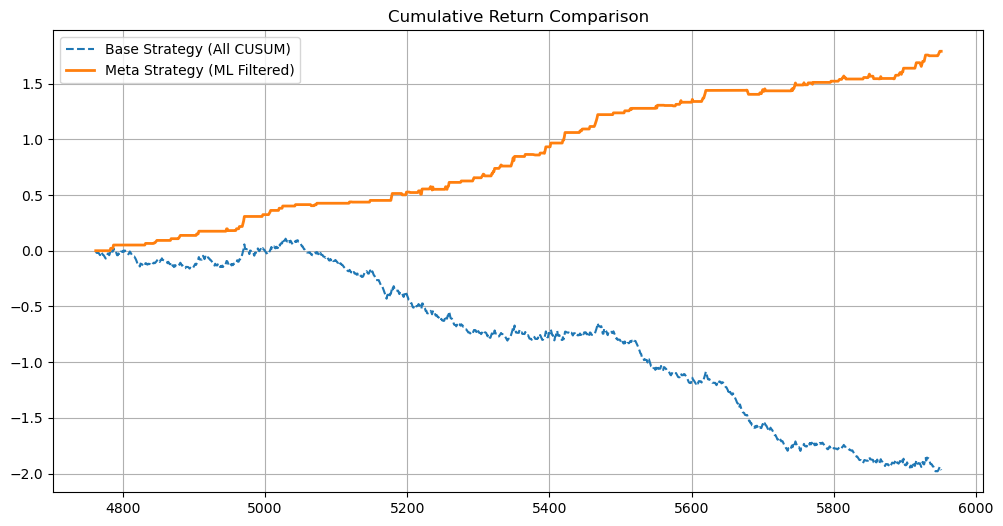


🎉 축하합니다! 이 모델은 돈을 벌 가능성이 높습니다.


In [6]:
# ==============================================================================
# [7단계] 실전 백테스팅 시뮬레이션
# ==============================================================================
print("\n--- 7. 백테스팅 시뮬레이션 ---")

# 테스트 데이터에 대한 예측 확률 가져오기
# (predict_proba의 2번째 컬럼이 Class 1일 확률)
y_probs = model.predict_proba(X_test)[:, 1]

# 임계값 설정 (보수적으로 0.6 이상일 때만 진입해 보자!)
threshold = 0.6
y_pred_filtered = (y_probs >= threshold).astype(int)

# 시뮬레이션용 데이터프레임 생성
backtest_df = X_test.copy()
backtest_df['actual_return'] = df_meta.loc[X_test.index, 'return']
backtest_df['model_signal'] = y_pred_filtered

# 1. 그냥 CUSUM 신호대로 다 들어갔을 때 (Base Strategy)
backtest_df['strategy_base'] = backtest_df['actual_return']

# 2. 모델이 "GO" 한 것만 들어갔을 때 (Meta Strategy)
backtest_df['strategy_meta'] = backtest_df['actual_return'] * backtest_df['model_signal']

# 누적 수익률 계산 (단리)
backtest_df['cum_base'] = backtest_df['strategy_base'].cumsum()
backtest_df['cum_meta'] = backtest_df['strategy_meta'].cumsum()

print(f"총 거래 횟수: {len(backtest_df)}")
print(f"모델 진입 횟수: {backtest_df['model_signal'].sum()}")
print(f"기본 전략 수익률: {backtest_df['strategy_base'].sum():.4f} (포인트)")
print(f"메타 전략 수익률: {backtest_df['strategy_meta'].sum():.4f} (포인트)")

# 그래프 그리기 (간단)
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(backtest_df['cum_base'], label='Base Strategy (All CUSUM)', linestyle='--')
    plt.plot(backtest_df['cum_meta'], label='Meta Strategy (ML Filtered)', linewidth=2)
    plt.title("Cumulative Return Comparison")
    plt.legend()
    plt.grid()
    plt.show()
except:
    print("matplotlib이 없어 그래프를 그릴 수 없습니다.")

# 최종 평가
if backtest_df['strategy_meta'].sum() > 0:
    print("\n🎉 축하합니다! 이 모델은 돈을 벌 가능성이 높습니다.")
else:
    print("\n😢 아직은 손실입니다. Feature를 더 추가하거나 임계값을 높여보세요.")


In [14]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, precision_recall_curve

# ==============================================================================
# [설정] 경로 및 파라미터
# ==============================================================================
RAW_DATA_PATH_4H = "eth_4hour_all.csv"
RAW_DATA_PATH_5M = "eth_5min_krw.csv"


ATR_MULTIPLIER_PROFIT = 3.0
ATR_MULTIPLIER_STOP = 1.5
FEE_RATE = 0.001 

# ==============================================================================
# [함수 1] 데이터 로드 및 표준화
# ==============================================================================
def load_and_standardize(path):
    print(f"loading {path}...")
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()
    
    # 시간 컬럼 찾기
    time_cols = ['timestamp', 'date', 'time', 'datetime', 'open_time', 'opentime']
    for col in time_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
            df.set_index(col, inplace=True)
            break
            
    # 컬럼명 통일 (eth_ 접두어 제거 등)
    rename_map = {}
    for col in df.columns:
        if 'eth_open' in col: rename_map[col] = 'open'
        elif 'eth_high' in col: rename_map[col] = 'high'
        elif 'eth_low' in col: rename_map[col] = 'low'
        elif 'eth_close' in col: rename_map[col] = 'close'
        elif 'eth_volume' in col: rename_map[col] = 'volume'
        
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
    
    return df

# ==============================================================================
# [함수 2] PnL Engine (Triple Barrier)
# ==============================================================================
def check_barrier_result(entry_time, entry_price, volatility, df_5m):
    start_time = entry_time
    end_time = start_time + pd.Timedelta(hours=4)
    
    tp_price = entry_price + (volatility * ATR_MULTIPLIER_PROFIT)
    sl_price = entry_price - (volatility * ATR_MULTIPLIER_STOP)
    
    try:
        subset = df_5m.loc[start_time:end_time]
        if subset.empty: return 0, -FEE_RATE
        
        for t, row in subset.iterrows():
            # 5분봉 데이터도 표준화가 안 되어 있을 수 있으므로 안전하게 처리
            h = row.get('high', row.get('eth_high', row[1])) # 인덱스로라도 접근
            l = row.get('low', row.get('eth_low', row[2]))
            c = row.get('close', row.get('eth_close', row[3]))
            
            if l <= sl_price:
                loss_pct = (sl_price - entry_price) / entry_price - FEE_RATE
                return 0, loss_pct
            if h >= tp_price:
                profit_pct = (tp_price - entry_price) / entry_price - FEE_RATE
                return 1, profit_pct
        
        # 시간 초과
        last_row = subset.iloc[-1]
        exit_price = last_row.get('close', last_row.get('eth_close'))
        final_ret = (exit_price - entry_price) / entry_price - FEE_RATE
        
        return (1, final_ret) if final_ret > 0 else (0, final_ret)
    except:
        return 0, -FEE_RATE

# ==============================================================================
# [함수 3] CUSUM Filter (Shift 반영)
# ==============================================================================
def get_cusum_events(close_prices, threshold_series):
    t_events = []
    s_pos, s_neg = 0, 0
    diff = close_prices.diff()
    is_dynamic = isinstance(threshold_series, pd.Series)
    
    for i in tqdm(diff.index[1:], desc="이벤트 샘플링"):
        try:
            current_diff = diff[i]
            if pd.isna(current_diff): continue
            h = threshold_series[i] if is_dynamic else threshold_series
            if pd.isna(h) or h <= 0: continue

            s_pos = max(0, s_pos + current_diff)
            s_neg = min(0, s_neg + current_diff)
            
            if s_pos > h:
                s_pos = 0; t_events.append(i)
            elif s_neg < -h:
                s_neg = 0; t_events.append(i)
        except: continue
    return pd.DatetimeIndex(t_events)

# ==============================================================================
# [메인 로직]
# ==============================================================================
print("--- 1. 데이터 로드 ---")
df_4h = load_and_standardize(RAW_DATA_PATH_4H)
df_5m = load_and_standardize(RAW_DATA_PATH_5M)

print("\n--- 2. 기술적 지표 계산 (Close 기준) ---")
# 기본 지표
df_4h['tr'] = df_4h['high'] - df_4h['low']
df_4h['ATR'] = df_4h['tr'].rolling(14).mean()

delta = df_4h['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df_4h['RSI'] = 100 - (100 / (1 + rs))

df_4h['BB_mid'] = df_4h['close'].rolling(20).mean()
df_4h['BB_std'] = df_4h['close'].rolling(20).std()
df_4h['BB_width'] = (4 * df_4h['BB_std']) / df_4h['BB_mid']
df_4h['volatility'] = df_4h['close'].pct_change().ewm(span=50).std() * df_4h['close']

# 추가 지표 (있으면 계산)
if 'btc_close' in df_4h.columns:
    df_4h['btc_ret'] = df_4h['btc_close'].pct_change()
    df_4h['btc_corr'] = df_4h['close'].rolling(24).corr(df_4h['btc_close']) # 24기간 상관계수

# 1. 파생 변수 생성 (이더리움 전용)
# (1) 이평선 이격도: 가격이 이평선에서 얼마나 떨어져 있나? (회귀 본능 vs 발산)
df_4h['ma20'] = df_4h['close'].rolling(20).mean()
df_4h['dist_ma20'] = (df_4h['close'] - df_4h['ma20']) / df_4h['ma20']

df_4h['ma60'] = df_4h['close'].rolling(60).mean()
df_4h['dist_ma60'] = (df_4h['close'] - df_4h['ma60']) / df_4h['ma60']

# (2) 거래량 변화율: 거래량이 갑자기 터졌나?
df_4h['vol_change'] = df_4h['volume'].pct_change()
df_4h['vol_ma20'] = df_4h['volume'].rolling(20).mean()
df_4h['vol_ratio'] = df_4h['volume'] / df_4h['vol_ma20'] # 평소 대비 몇 배?

# (3) MACD (단기/장기 추세선)
exp12 = df_4h['close'].ewm(span=12, adjust=False).mean()
exp26 = df_4h['close'].ewm(span=26, adjust=False).mean()
df_4h['macd'] = exp12 - exp26
df_4h['macd_signal'] = df_4h['macd'].ewm(span=9, adjust=False).mean()
df_4h['macd_hist'] = df_4h['macd'] - df_4h['macd_signal']

# (4) ATR (Feature용) - 이미 계산된 'ATR' 컬럼 사용

# 2. Feature 목록 재정의 (이더리움 위주)
potential_features = [
    # --- 이더리움 핵심 기술적 지표 ---
    'RSI', 'BB_width', 'volatility', 'ATR', 
    'dist_ma20', 'dist_ma60', # 이격도
    'macd', 'macd_hist',      # 추세
    'vol_change', 'vol_ratio', # 거래량 파워
    
    # --- 시장 심리 & 온체인 ---
    'fundingrate', 'fear_greed', 'open_interest',
    
    # --- 비트코인 (보조) ---
    'btc_ret', 'btc_corr', 'btc_volume',
    
    # --- 시간 & 거시 ---
    'hour_sin', 'hour_cos', 'dxy_pct_chg_24h'
]

available_features = []
cols_lower = {col.lower(): col for col in df_4h.columns}

for feat in potential_features:
    if feat.lower() in cols_lower:
        available_features.append(cols_lower[feat.lower()])
    else:
        # 새로 만든 파생변수는 df_4h에 있으므로 바로 추가
        if feat in df_4h.columns:
            available_features.append(feat)
            
print(f"사용할 Feature ({len(available_features)}개): {available_features}")

# ★ 핵심: 모든 Feature를 한 칸 미룸 (t-1 시점의 정보로 t 시점 예측)
df_features = df_4h[available_features].shift(1)
df_features.dropna(inplace=True)

# 3. (옵션) 데이터 정제: inf 값 제거 (나눗셈 때문에 생길 수 있음)
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
df_features.dropna(inplace=True)


print("\n--- 4. CUSUM 필터 (Shifted Close 기준) ---")
# CUSUM 신호도 '직전 봉' 기준으로 발생해야 함
shifted_close = df_4h['close'].shift(1)
shifted_vol = df_4h['volatility'].shift(1)

# 변동성의 1.0배를 트리거로 사용
entry_signals = get_cusum_events(shifted_close, shifted_vol * 1.0)
print(f"-> 추출된 신호: {len(entry_signals)}개")

print("\n--- 5. 라벨링 (Next Open 진입) ---")
meta_label_data = []


df_4h['tr_val'] = df_4h['high'] - df_4h['low']
df_4h['real_atr'] = df_4h['tr_val'].rolling(14).mean()

for entry_time in tqdm(entry_signals, desc="라벨링"):
    if entry_time not in df_4h.index: continue
    
    current_row = df_4h.loc[entry_time]
    entry_price = current_row['open']
    
    # Feature 가져오기
    if entry_time not in df_features.index: continue
    past_row = df_features.loc[entry_time]
    
    # [수정] 변동성 가져오기: Feature의 NATR 말고, df_4h의 real_atr(절대값) 사용
    # (직전 봉 기준이므로 4시간 전 데이터를 가져옴)
    prev_time = entry_time - pd.Timedelta(hours=4)
    
    if prev_time in df_4h.index:
        vol_val = df_4h.loc[prev_time, 'real_atr'] # 절대값 ATR
    else:
        vol_val = entry_price * 0.01 # 1% 안전장치
        
    if pd.isna(vol_val) or vol_val == 0: vol_val = entry_price * 0.01

    # 이제 정상적인 ATR(예: 50000원)이 들어감 -> 익절/손절폭 정상화
    label, ret = check_barrier_result(entry_time, entry_price, vol_val, df_5m)
    
    row_dict = {
        'entry_time': entry_time,
        'target': label,
        'return': ret
    }
    
    for feat in available_features:
        row_dict[feat] = past_row[feat]
        
    meta_label_data.append(row_dict)

df_meta = pd.DataFrame(meta_label_data).dropna()
print(f"최종 데이터: {len(df_meta)}개")

print("\n--- 6. LGBM 학습 및 평가 ---")
if not df_meta.empty:
    X = df_meta[available_features]
    y = df_meta['target']
    
    # 최근 20% 테스트
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # 모델 학습
    model = LGBMClassifier(n_estimators=200, learning_rate=0.03, num_leaves=31, random_state=42, verbose=-1)
    model.fit(X_train, y_train)
    
    # 평가
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # 임계값 분석
    y_probs = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
    
    print("\n[임계값별 승률 분석]")
    print(f"{'Threshold':<10} | {'Precision':<10} | {'Recall':<10}")
    for t in np.arange(0.5, 0.8, 0.05):
        idx = np.argmin(np.abs(thresholds - t))
        print(f"{t:.2f}       | {precisions[idx]:.4f}     | {recalls[idx]:.4f}")
        
    # Feature Importance
    print("\n[Top 5 Features]")
    imp = pd.DataFrame({'feat': available_features, 'gain': model.feature_importances_})
    print(imp.sort_values('gain', ascending=False).head(5))

else:
    print("데이터가 너무 적어서 학습 불가")


--- 1. 데이터 로드 ---
loading eth_4hour_all.csv...
loading eth_5min_krw.csv...

--- 2. 기술적 지표 계산 (Close 기준) ---
사용할 Feature (18개): ['RSI', 'BB_width', 'volatility', 'ATR', 'dist_ma20', 'dist_ma60', 'macd', 'macd_hist', 'vol_change', 'vol_ratio', 'fundingrate', 'fear_greed', 'btc_ret', 'btc_corr', 'btc_volume', 'hour_sin', 'hour_cos', 'dxy_pct_chg_24h']

--- 4. CUSUM 필터 (Shifted Close 기준) ---


이벤트 샘플링: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17935/17935 [00:00<00:00, 65910.91it/s]


-> 추출된 신호: 5959개

--- 5. 라벨링 (Next Open 진입) ---


라벨링: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5959/5959 [00:13<00:00, 433.59it/s]


최종 데이터: 5940개

--- 6. LGBM 학습 및 평가 ---
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       641
           1       0.50      0.36      0.42       547

    accuracy                           0.54      1188
   macro avg       0.53      0.53      0.52      1188
weighted avg       0.53      0.54      0.53      1188


[임계값별 승률 분석]
Threshold  | Precision  | Recall    
0.50       | 0.5038     | 0.3620
0.55       | 0.5085     | 0.2176
0.60       | 0.4872     | 0.1042
0.65       | 0.5577     | 0.0530
0.70       | 0.4643     | 0.0238
0.75       | 0.3000     | 0.0055
0.80       | 0.6667     | 0.0037

[Top 5 Features]
          feat  gain
14  btc_volume   499
11  fear_greed   494
13    btc_corr   478
9    vol_ratio   455
12     btc_ret   412



--- Final Strategy Backtest ---
전체 테스트 기간 수익률: 0.1200 (단리 합산)
총 진입 횟수: 51회
승률 (Win Rate): 56.86%


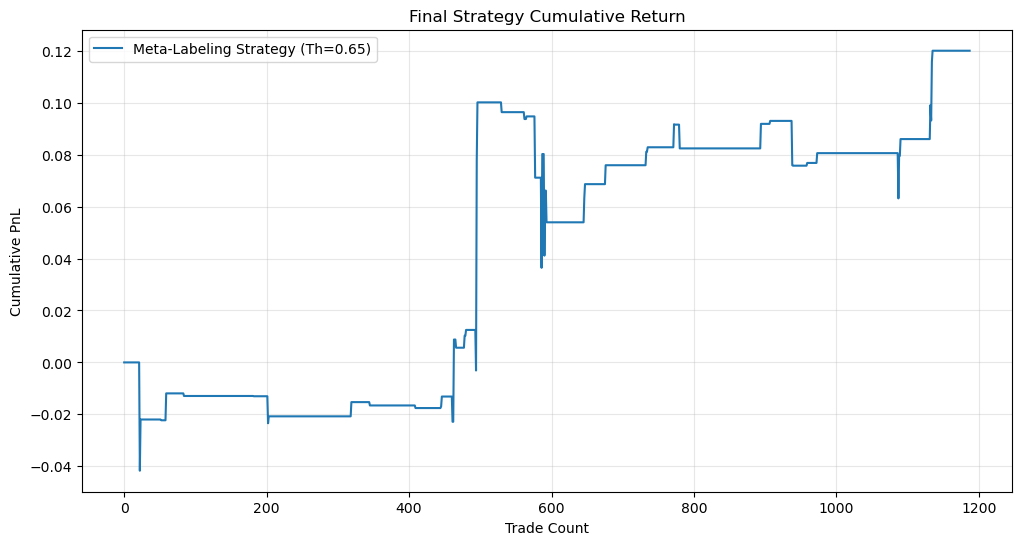

In [16]:
# ==============================================================================
# [Final] 전략 수익률 시뮬레이션 (Threshold 0.65 적용)
# ==============================================================================
import matplotlib.pyplot as plt

print("\n--- Final Strategy Backtest ---")

# 1. 예측 확률 가져오기
y_probs = model.predict_proba(X_test)[:, 1]

# 2. 전략 필터링 (Threshold 0.65)
threshold = 0.65
signals = (y_probs >= threshold).astype(int)

# 3. 수익률 계산
test_returns = df_meta.loc[X_test.index, 'return']
strategy_returns = test_returns * signals  # 신호 뜬 것만 수익률 반영, 나머지는 0

# 4. 누적 수익률 (Cumulative Return)
# 수수료(0.1%)는 이미 check_barrier_result에서 차감됨
cum_returns = strategy_returns.cumsum()

# 5. 결과 출력
total_trades = signals.sum()
win_rate = strategy_returns[strategy_returns > 0].count() / total_trades if total_trades > 0 else 0
total_return = strategy_returns.sum()

print(f"전체 테스트 기간 수익률: {total_return:.4f} (단리 합산)")
print(f"총 진입 횟수: {total_trades}회")
print(f"승률 (Win Rate): {win_rate:.2%}")

# 6. 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(cum_returns.values, label=f'Meta-Labeling Strategy (Th={threshold})')
plt.title('Final Strategy Cumulative Return')
plt.xlabel('Trade Count')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
